In [45]:
import pandas as pd
import numpy as np
import glob
import random

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, sampler
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from apex import amp

In [46]:
# The images are in folder images already in good shape (224, 224)
# Retrieve path for each image
list_path = glob.glob("./images/images/*.png")

In [47]:
list_path[:3]

['./images/images/00016184_034.png',
 './images/images/00004858_029.png',
 './images/images/00014918_012.png']

In [48]:
# Extract name of files
files = [x.split('/')[-1] for x in list_path]

In [49]:
len(files)

27534

In [50]:
df_labels = pd.read_csv('Data_Entry_2017_v2020.csv')
df_labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [51]:
df_labels.shape

(112120, 11)

In [52]:
train_id = pd.read_table('train_val_list.txt', header=None)
test_id = pd.read_table('test_list.txt', header=None)

In [53]:
def define_data(list_path, files, df_labels, train_id, test_id):

    train_id['set'] = 'train'
    train_id.columns = ['image', 'set']
    
    test_id['set'] = 'test'
    test_id.columns = ['image', 'set']
    
    train_val_test_ids = pd.concat([train_id, test_id])
    
    df = df_labels[['Image Index', 'Finding Labels']]
    df['label'] = [1 if 'Pneumonia' in x.split('|') else 0 for x in df['Finding Labels']]
    df = df.drop(columns=['Finding Labels'])
    df.columns = ['image', 'label']
    
    df_paths = pd.DataFrame({'path': list_path, 'image': files})
    df = df.merge(df_paths, on='image', how='left')
    df = df.merge(train_val_test_ids, on='image', how='left')
    df = df.dropna()
    
    return df

In [54]:
df = define_data(list_path, files, df_labels, train_id, test_id)
df.head()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,image,label,path,set
5006,00001340_000.png,0,./images/images/00001340_000.png,train
5007,00001341_000.png,0,./images/images/00001341_000.png,train
5017,00001348_000.png,0,./images/images/00001348_000.png,train
5018,00001349_000.png,0,./images/images/00001349_000.png,train
5019,00001350_000.png,0,./images/images/00001350_000.png,train


In [55]:
train = df[df.set=='train']
test = df[df.set=='test']

In [56]:
len(train), len(test)

(21508, 6026)

In [57]:
X = train['path']
y = train['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [58]:
len(X_train), len(X_val)

(19357, 2151)

# Dataset

In [59]:
def preprocessing_steps(im):
    """
    Pre-process image. Reshape to model input shape and normalize the data with Imagenet stats.
    """
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    im =  (im - imagenet_stats[0])/imagenet_stats[1]
    return im

In [60]:
class ChestXRayDataset(Dataset):
 
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        im = cv2.imread(self.x.iloc[idx])
        im = preprocessing_steps(im)
        # Horizontal Flip
        if np.random.random() > 0.5: 
            im = np.fliplr(im).copy()
        return np.rollaxis(im, 2), self.y.iloc[idx]

In [61]:
# Balanced sampling data
class_sample_count = np.array([len(np.where(y_train==t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

samples_weight = torch.from_numpy(samples_weight)
samp = sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [62]:
train_ds = ChestXRayDataset(X_train, y_train)
valid_ds = ChestXRayDataset(X_val, y_val)

train_dl = DataLoader(train_ds, batch_size=8, sampler=samp)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=False)

In [63]:
x, y = next(iter(train_dl))

In [64]:
x.shape, y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [65]:
y

tensor([1, 0, 0, 1, 0, 1, 0, 0])

# Model

In [66]:
resnet = models.resnet18(pretrained=True)

In [67]:
layers = list(resnet.children())
print(len(layers))

10


In [68]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1))
    
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

# Learning rate finder

In [70]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]


In [71]:
def LR_range_finder(model, train_dl, lr_low=1e-4, lr_high=0.01, epochs=2):
    losses = []
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    optimizer = create_optimizer(model, lrs[0])
    model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                      keep_batchnorm_fp32=True, loss_scale="dynamic")
    ind = 0
    for i in range(epochs):
        for x, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr])
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y.unsqueeze(1))
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    return lrs, losses

In [72]:
bs = 350
train_dl = DataLoader(train_ds, batch_size=bs, sampler=samp)
valid_dl = DataLoader(valid_ds, batch_size=bs)

In [73]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


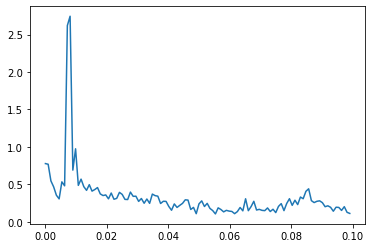

In [74]:
plt.plot(lrs, losses)
plt.show()

# Training

In [75]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

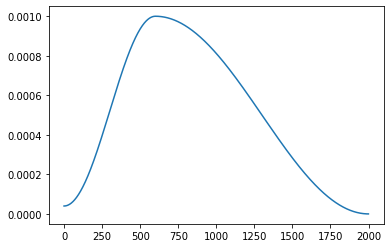

In [76]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [77]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)
    
def load_model(m, p): 
    m.load_state_dict(torch.load(p))

In [78]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr])
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().float()
        out = model(x)
        loss = F.binary_cross_entropy_with_logits(out, y.unsqueeze(1))
        optimizer.zero_grad()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [98]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs=5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    model, optimizer = amp.initialize(model, optimizer, opt_level="O2", 
                                      keep_batchnorm_fp32=True, loss_scale="dynamic")
    prev_val_acc = 0.90
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc >= prev_val_acc: 
            prev_val_acc = val_acc
            path = "models/model_resnet18_{0:.0f}.pth".format(100*val_acc)
            save_model(model, path)
            print(path)

In [99]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    with torch.no_grad():
        for x, y in valid_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().float()
            out = model(x)
            pred = (out > 0.0).long()
            y = y.unsqueeze(1)
            correct += pred.eq(y.data).sum().item()
            loss = F.binary_cross_entropy_with_logits(out, y)
            sum_loss += batch*(loss.item())
            total += batch
        return sum_loss/total, correct/total

In [100]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.01, epochs=15)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
train_loss 0.101 val_loss 0.104 val_acc 0.990
models/model_resnet18_99.pth
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
train_loss 0.129 val_loss 2.003 val_acc 0.628
train_loss 0.054 val_

# Test results

In [102]:
X_test = test['path']
y_test = test['label']

In [103]:
test_ds = ChestXRayDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, shuffle=False)

In [105]:
model = Net().cuda()
load_model(model, "models/model_resnet18_99.pth")

In [106]:
test_loss, test_acc = val_metrics(model, test_dl)

In [107]:
test_acc

0.9766013939595088